# TEPs Output Analysis

This notebook was copied from `20200218-tepsrerunwithnewdata`, and analyzes the results of a TEPs run in December 2020 that includes 2017-2019 data without any 7.5 hour converted TMCs - *proposed* - with the TEPS run including 2017-2018 data already sent to EED earlier this year - *baseline*.  They're both located in `VolumeModel\TEPS-EEDrun`.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats import multitest

In [2]:
import configparser
import pathlib
import psycopg2

config = configparser.ConfigParser()
config.read(pathlib.Path.home().joinpath('.charlesconfig').as_posix());
postgres_settings = config['POSTGRES']

In [3]:
path_baseline = "/mnt/c/Users/czhu5/Documents/VolumeModel/TEPS-I-EEDrun/aadt_output_files/bdit_traffic_prophet_issue41/"
path_proposed = "/mnt/c/Users/czhu5/Documents/VolumeModel/TEPS-I-EEDrun/aadt_output_files/"

In [5]:
centreline_lengths = pd.read_csv(
    "/mnt/c/Users/czhu5/Documents/VolumeModel/TEPS-I-EEDrun/KCOUNT/RMsma_2km_pos/centreline_length.csv")

## Z-Score distribution comparison

We'll treat each AADT estimates as $\mathcal{N}(\mu, \Sigma)$, where $\mu$ is the AADT reported and $\Sigma$ can be back-calculated using the 95% CIs.

Recall that the difference of two normally distributed RVs is:

$$
\mathcal{N}(\mu_1 \Sigma_1) - \mathcal{N}(\mu_2, \Sigma_2) \sim \mathcal{N}(\mu_1 - \mu_2, \Sigma_1 + \Sigma_2)
$$

In [6]:
twosigma = stats.norm.ppf(0.975, loc=0, scale=1)

def read_csv(path, year):
    df = pd.read_csv(path + "final_aadt_{0}.csv".format(year), usecols=list(range(5)))
    df.columns = [x.strip() for x in df.columns.values]
    df.loc[df['LowerBound'] == 9999., 'LowerBound'] = np.nan
    df.loc[df['UpperBound'] == 9999., 'UpperBound'] = np.nan
    # LowerBound and UpperBound are symmetric.
    df['stdev'] = (df['UpperBound'] - df['aadt']) / twosigma
    return df

In [7]:
twosigma = stats.norm.ppf(0.975, loc=0, scale=1)

def z_dist(path1, path2, year, title):
    # See also https://www.sciencedirect.com/science/article/pii/S0741521402000307
    
    df1 = read_csv(path1, year).dropna()
    df2 = read_csv(path2, year).dropna()
    
    df = pd.merge(df1, df2, how='inner', on=('centreline_id', 'dir_bin'),
                  suffixes=('_1', '_2'))

    df['aadt_difference'] = df['aadt_1'].values - df['aadt_2'].values
    df['difference_stdev'] = (df['stdev_1'].values**2 + df['stdev_2'].values**2)**0.5
    # Z = (val - mean) / std, of course.
    df['z_score'] = df['aadt_difference'].values / df['difference_stdev'].values
    # sf is Survival function
    # https://stackoverflow.com/questions/3496656/convert-z-score-z-value-standard-score-to-p-value-for-normal-distribution-in
    df['p_val'] = stats.norm.sf(abs(df['z_score'].values), loc=0, scale=1)

    zvals = np.linspace(-3, 3, 1000)
    pdfvals = stats.norm.pdf(zvals)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(zvals, pdfvals, lw=3)
    ax.hist(df['z_score'].values, bins=100, range=(-3., 3.), density=True)
    ax.set_xlim([-2., 2.]);
    ax.set_xlabel("Z-Score", fontsize=16)
    ax.tick_params(axis='both', which='both', labelsize=14)
    ax.set_ylabel("PDF", fontsize=16)
    ax.set_title(title, fontsize=18)
    
    # Return AADT estimates where we can reject the null hypothesis that the two
    # datasets are drawn from the same distribution.  Use Holm-Sidak adjusted
    # p-values.
    # https://www.statsmodels.org/stable/generated/statsmodels.stats.multitest.multipletests.html
    reject, pvals_corrected, alphacSidak, alphacBonf = multitest.multipletests(df['p_val'].values, alpha=0.05)
    df['p_val_HScorrected'] = pvals_corrected
    
    return df.loc[reject, :]

### Distribution between baseline and proposed

,centreline_id,dir_bin,aadt_1,LowerBound_1,UpperBound_1,stdev_1,aadt_2,LowerBound_2,UpperBound_2,stdev_2,aadt_difference,difference_stdev,z_score,p_val,p_val_HScorrected
282,1048,1,21980.732910,20788.328970,23173.136850,608.380536,15658.786680,14932.387280,16385.186080,370.618749,6321.946230,712.379908,8.874403,3.515484e-19,0.000000e+00
325,1152,1,9270.675094,8483.652473,10057.697720,401.549535,11922.072780,11185.744470,12658.401100,375.684618,-2651.397686,549.891772,-4.821672,7.117999e-07,2.212905e-02
404,1395,-1,9800.225977,8795.869253,10804.582700,512.436316,6370.340517,5817.570968,6923.110065,282.030462,3429.885460,584.920643,5.863848,2.261314e-09,7.137584e-05
522,1712,-1,10818.050830,9893.246662,11742.855000,471.847533,7168.228913,6608.532568,7727.925258,285.564607,3649.821917,551.531721,6.617610,1.825261e-11,5.769652e-07
1956,104598,1,6966.273147,6280.126272,7652.420022,350.081369,9924.992629,9112.159460,10737.825800,414.718422,-2958.719482,542.723074,-5.451619,2.495664e-08,7.863488e-04


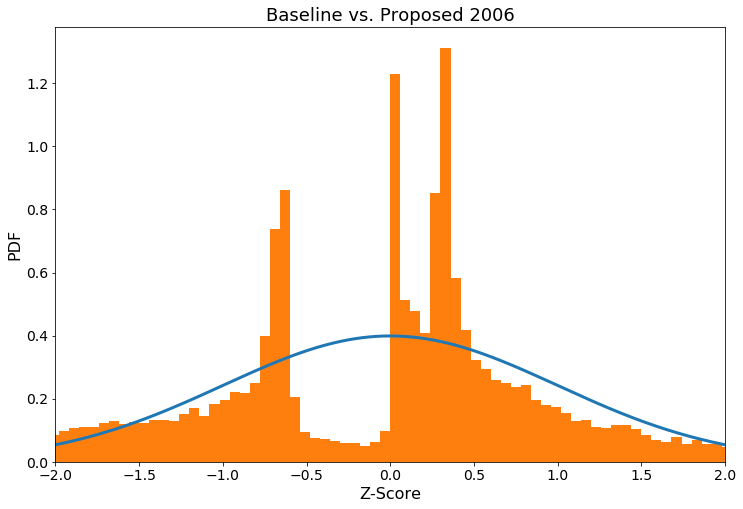

In [10]:
rejects = z_dist(path_baseline, path_proposed, 2006, "Baseline vs. Proposed 2006")
rejects.head()

,centreline_id,dir_bin,aadt_1,LowerBound_1,UpperBound_1,stdev_1,aadt_2,LowerBound_2,UpperBound_2,stdev_2,aadt_difference,difference_stdev,z_score,p_val,p_val_HScorrected
271,1022,-1,46418.71127,45108.661820,47728.76072,668.404859,55708.374300,54006.375590,57410.373010,868.382646,-9289.663030,1095.834602,-8.477249,1.152903e-17,0.000000
282,1048,1,22629.66800,21505.596990,23753.73901,573.516156,16691.146480,15938.502000,17443.790970,384.009347,5938.521520,690.205737,8.603987,3.849669e-18,0.000000
404,1395,-1,10546.88479,9452.867046,11640.90253,558.182573,7039.332535,6422.717685,7655.947384,314.605194,3507.552255,640.737242,5.474244,2.196912e-08,0.000694
522,1712,-1,11642.25559,10688.424320,12596.08686,486.657550,8531.302216,7909.959396,9152.645037,317.017469,3110.953374,580.806031,5.356269,4.247898e-08,0.001342
695,7482,1,25781.71613,24967.080450,26596.35181,415.638086,28507.143020,27741.978790,29272.307260,390.397092,-2725.426890,570.232328,-4.779503,8.786470e-07,0.027353


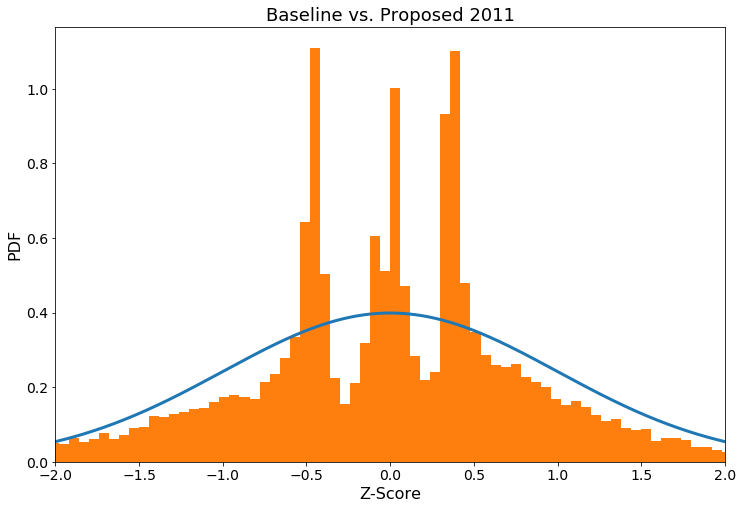

In [11]:
rejects = z_dist(path_baseline, path_proposed, 2011, "Baseline vs. Proposed 2011")
rejects.head()

,centreline_id,dir_bin,aadt_1,LowerBound_1,UpperBound_1,stdev_1,aadt_2,LowerBound_2,UpperBound_2,stdev_2,aadt_difference,difference_stdev,z_score,p_val,p_val_HScorrected
271,1022,-1,42240.56233,41162.29024,43318.83442,550.148931,54980.354730,53462.093220,56498.616240,774.637454,-12739.792400,950.119482,-13.408621,2.691509e-41,0.000000e+00
282,1048,1,23297.76154,22257.94035,24337.58273,530.530764,18545.091120,17781.799700,19308.382540,389.441554,4752.670420,658.124316,7.221539,2.570124e-13,8.133805e-09
400,1377,-1,12044.58054,11243.14262,12846.01846,408.904412,9358.474867,8678.588818,10038.360920,346.887013,2686.105673,536.221426,5.009322,2.731109e-07,8.556347e-03
404,1395,-1,11350.42998,10102.53404,12598.32592,636.693301,7297.835747,6538.268048,8057.403445,387.541661,4052.594233,745.363602,5.437070,2.708190e-08,8.532573e-04
522,1712,-1,12529.25481,11409.61133,13648.89829,571.257170,9318.626074,8560.660322,10076.591830,386.724329,3210.628736,689.848144,4.654109,1.626920e-06,4.981478e-02


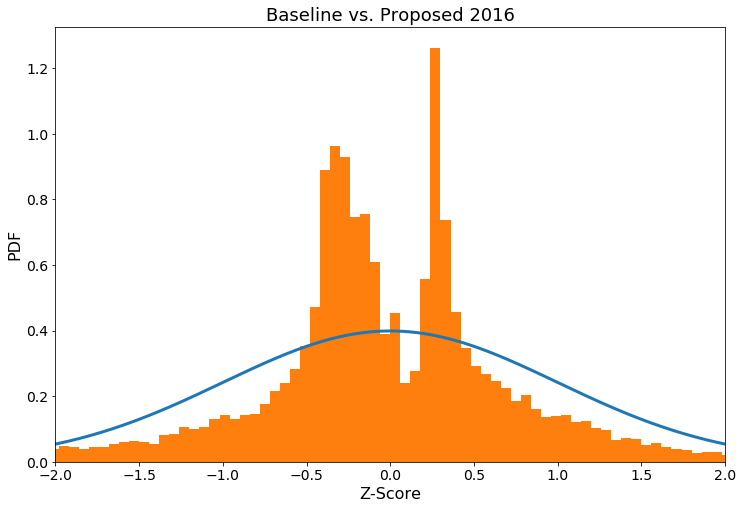

In [12]:
rejects = z_dist(path_baseline, path_proposed, 2016, "Baseline vs. Proposed 2016")
rejects.head()

,centreline_id,dir_bin,aadt_1,LowerBound_1,UpperBound_1,stdev_1,aadt_2,LowerBound_2,UpperBound_2,stdev_2,aadt_difference,difference_stdev,z_score,p_val,p_val_HScorrected
271,1022,-1,40676.57108,39706.33168,41646.81048,495.029198,54691.81784,53161.57042,56222.06526,780.752826,-14015.24676,924.461401,-15.160446,3.231470e-52,0.000000
281,1048,-1,22952.99358,21979.32116,23926.66600,496.780771,9922.48401,9570.84471,10274.12331,179.411103,13030.50957,528.185080,24.670348,1.113154e-134,0.000000
282,1048,1,23570.48946,22707.12455,24433.85437,440.500395,19710.88854,18936.61953,20485.15754,395.042463,3859.60092,591.691766,6.522992,3.445917e-11,0.000001
317,1134,1,12998.28301,12078.26605,13918.29997,469.405034,16105.57237,15227.42033,16983.72441,448.044988,-3107.28936,648.910931,-4.788468,8.402959e-07,0.025908
321,1146,1,12642.30640,11767.86268,13516.75012,446.152953,15886.84445,15054.08699,16719.60190,424.884057,-3244.53805,616.099765,-5.266254,6.961768e-08,0.002181


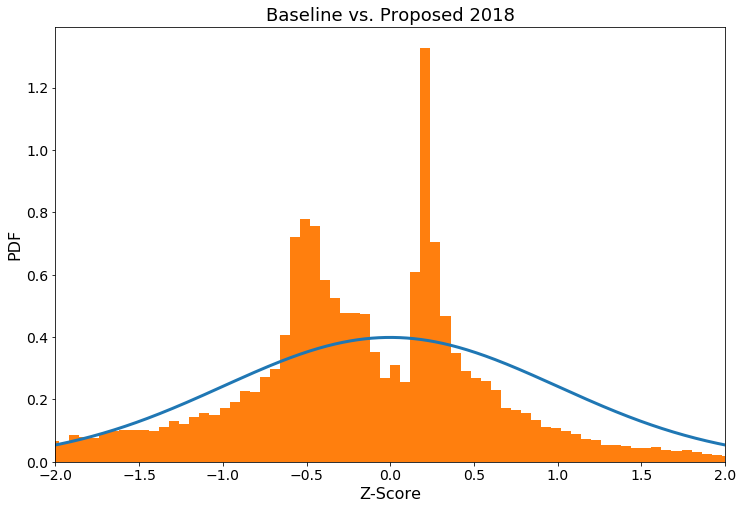

In [15]:
rejects = z_dist(path_baseline, path_proposed, 2018, "Baseline vs. Proposed 2018")
rejects.head()

Unlike for `20200218-tepsrerunwithnewdata`, there is no sharp peak with a z-score of zero for any year being considered. For example, in 2011 it appears there's actually a *deficit* of predictions close to $z = 0$ compared to those that are half a sigma larger or smaller (peaks at $z = \pm 0.5$). While estimates for all years are substantially different, they still appear to be more substantially different for earlier years, as we saw in `20200218-tepsrerunwithnewdata`.

All this said, I still don't fully understand how the 95% CI is even being calculated here, so let's just compare absolute values.

## Baseline vs recalc & proposed across all years

Now we'll look at the absolute and absolute fractional deviation between predicted AADTs from Arman's OneDrive `baseline` my `proposed` ones.

In [32]:
import matplotlib.ticker as mtk

def x_dist(path1, path2, year):
    # See also https://www.sciencedirect.com/science/article/pii/S0741521402000307
    
    df1 = read_csv(path1, year).dropna()
    df2 = read_csv(path2, year).dropna()
    
    df = pd.merge(df1, df2, how='inner', on=('centreline_id', 'dir_bin'),
                  suffixes=('_1', '_2'))

    df['aadt_difference'] = df['aadt_1'].values - df['aadt_2'].values
    
    df['aadt_percent_difference'] = abs(df['aadt_difference']) / df['aadt_1']

    return df

def multiyear_deviation_diagnostic(path_1, path_2, xlabel, ylabel):
    fig1, axs1 = plt.subplots(3, 4, figsize=(15, 12))
    fig1.subplots_adjust(left=0.1, right=0.92, bottom=0.1, top=0.925)

    fig2, axs2 = plt.subplots(3, 4, figsize=(15, 12))
    fig2.subplots_adjust(left=0.1, right=0.92, bottom=0.1, top=0.925)

    for idx, year in enumerate(range(2007, 2019)):
        i = idx // 4
        j = idx % 4

        dft = x_dist(path_1, path_2, year)

        maxval = max([dft['aadt_1'].max(), dft['aadt_2'].max()])
        axs1[i, j].plot([0, maxval], [0, maxval], 'b--', lw=1)
        axs1[i, j].plot(dft['aadt_1'], dft['aadt_2'], 'ro', ms=1)
        axs1[i, j].set(xlim=[0, maxval], ylim=[0, maxval], aspect=1, title=str(year))
        axs1[i, j].axes.ticklabel_format(axis='both', style='sci', scilimits=(0, 0))
        axs1[i, j].xaxis.set_major_locator(mtk.MultipleLocator(2e4))
        axs1[i, j].yaxis.set_major_locator(mtk.MultipleLocator(2e4))

        axs2[i, j].plot(dft['aadt_1'], dft['aadt_percent_difference'], 'bo', ms=1)
        axs2[i, j].axes.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
        axs2[i, j].set(yscale='log', title=str(year), ylim=[1e-4, 1e1])

    fig1.text(0.5, 0.05, xlabel, ha='center', fontsize=14)
    fig1.text(0.05, 0.5, ylabel, va='center', rotation='vertical', fontsize=14)
    fig1.suptitle("{0} vs. {1} Values".format(ylabel, xlabel), fontsize=18)

    fig2.text(0.5, 0.05, xlabel, ha='center', fontsize=14)
    fig2.text(0.05, 0.5, 'Fractional Deviation', va='center', rotation='vertical', fontsize=14)
    fig2.suptitle("{0} vs. {1} Absolute Fractional Error".format(ylabel, xlabel), fontsize=18)

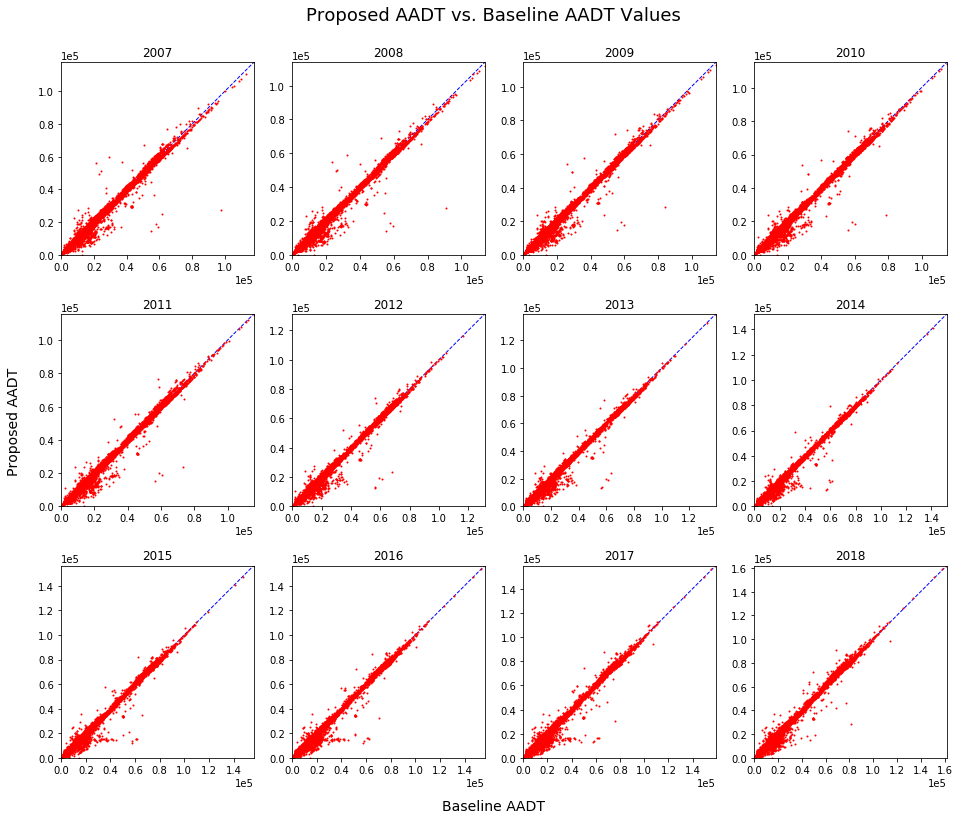

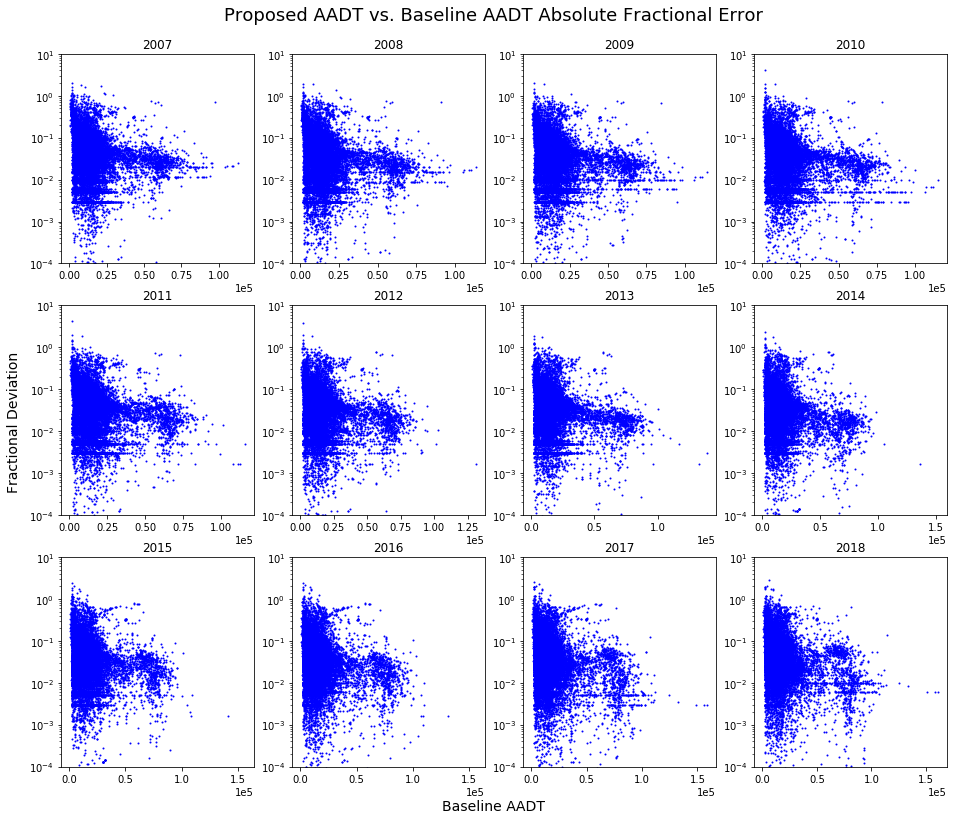

In [33]:
multiyear_deviation_diagnostic(path_baseline, path_proposed, "Baseline AADT", "Proposed AADT")

In the absolute value plot, we see two distributions - one that lands pretty closely to the y = x line (blue dashed), and a tail of outliers shallower than y = x close to the origin. In the relative difference plot, errors at extremely large AADTs are typically at or below the 10% level while there's a tail of 100-1000% error for very small AADTs.  The shallow tail of outliers in the absolute plot can also be seen in the relative plot at around 30% relative error and < 0.5e5 baseline AADT.

## Baseline vs proposed map

I also want to check that these errors are not geospatially clustered.  We can do this by plotting the fractional deviation on a map for a given year:

In [22]:
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib as mpl

with psycopg2.connect(database='bigdata', **postgres_settings) as db_con:
    # Read in data.
    sql_query = ("SELECT centreline_id, fcode_desc, geom, lon, lat,"
                 "ST_SetSRID(ST_MakePoint(lon, lat), 4326) point_geom "
                 "FROM czhu.btp_centreline_lonlat")
    ctrline_geoms = gpd.read_postgis(sql_query, db_con)
    ctrline_geoms['centreline_id'] = ctrline_geoms['centreline_id'].astype(int)

def map_fractional_err(path_1, path_2, year, title, filename=None):
    dft = x_dist(path_1, path_2, year)
    dft = pd.merge(ctrline_geoms[['centreline_id', 'geom']],
                   dft[['centreline_id', 'aadt_percent_difference']],
                   how='inner', on='centreline_id')
    dft = gpd.GeoDataFrame(dft, crs={'init': 'epsg:4326'}, geometry='geom')

    fig = plt.figure(figsize=(14, 8))
    fig.patch.set_facecolor('#1c1c1c')
    ax = fig.add_axes([0., 0., 0.8, 1.])
    ax.axis('off')
    ax.set_title(title, fontsize=14, color='w')
    # Not absolute minimum, for more color dynamics.
    im = dft.to_crs(epsg=3857).plot(column='aadt_percent_difference', ax=ax,
                                    cmap='viridis', norm=colors.LogNorm(),
                                    vmin=1e-2, vmax=1.)
    cbax = fig.add_axes([0.8, 0., 0.025, 1.])
    cb1 = mpl.colorbar.ColorbarBase(cbax, cmap=mpl.cm.viridis,
                                    norm=colors.LogNorm(vmin=1e-2, vmax=1.),
                                    orientation='vertical')
    cb1.ax.tick_params(axis='both', which='both', labelsize=12, pad=15, length=10,
                       width=1.5, labelcolor='white', colors='white')
    cb1.ax.set_ylabel('Fractional AADT Error', fontsize=15, color='white')

    if filename is not None:
        # Output to QGIS to check local continuity of error estimates.
        dft.to_file(filename)

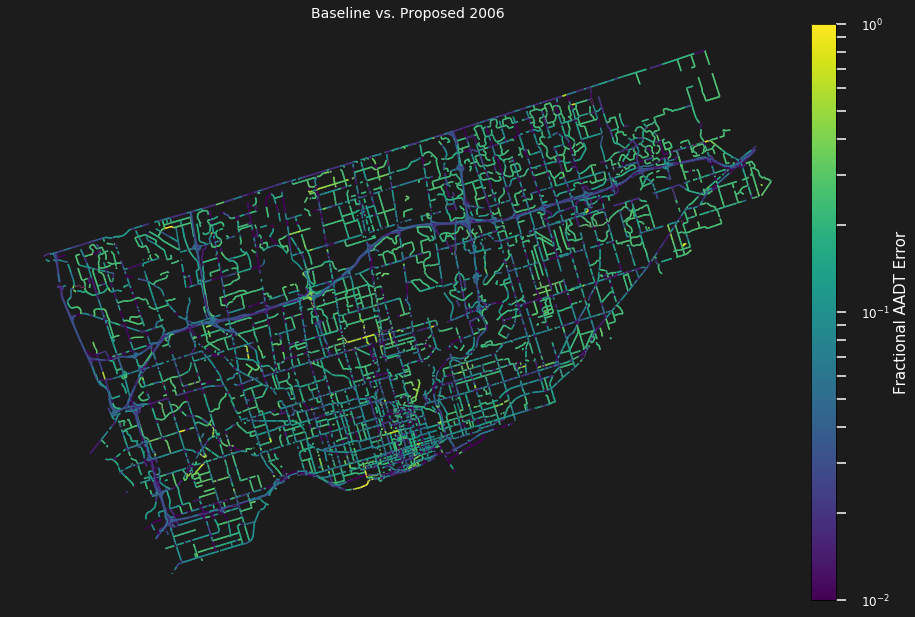

In [23]:
map_fractional_err(path_baseline, path_proposed, 2006, "Baseline vs. Proposed 2006")

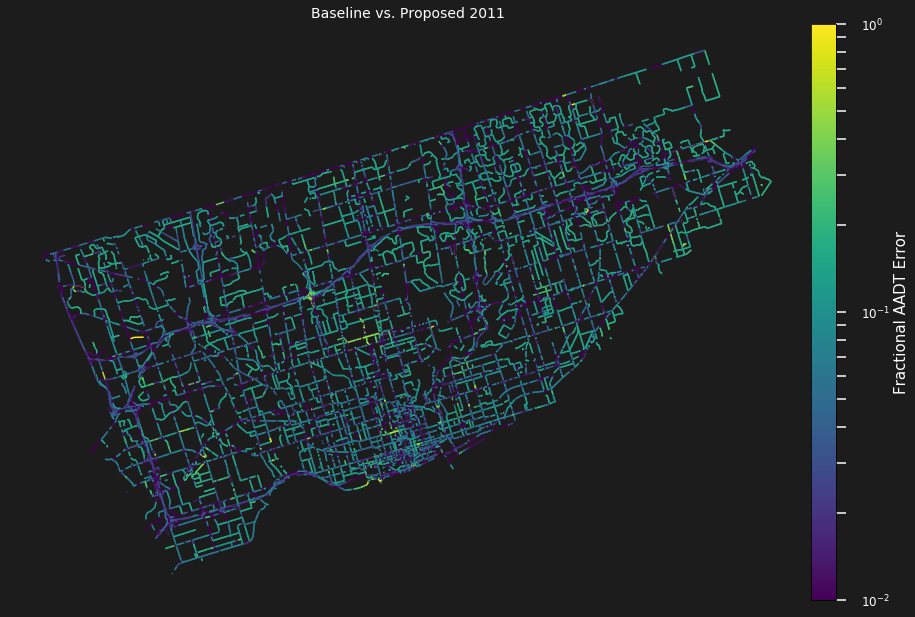

In [24]:
map_fractional_err(path_baseline, path_proposed, 2011, "Baseline vs. Proposed 2011")

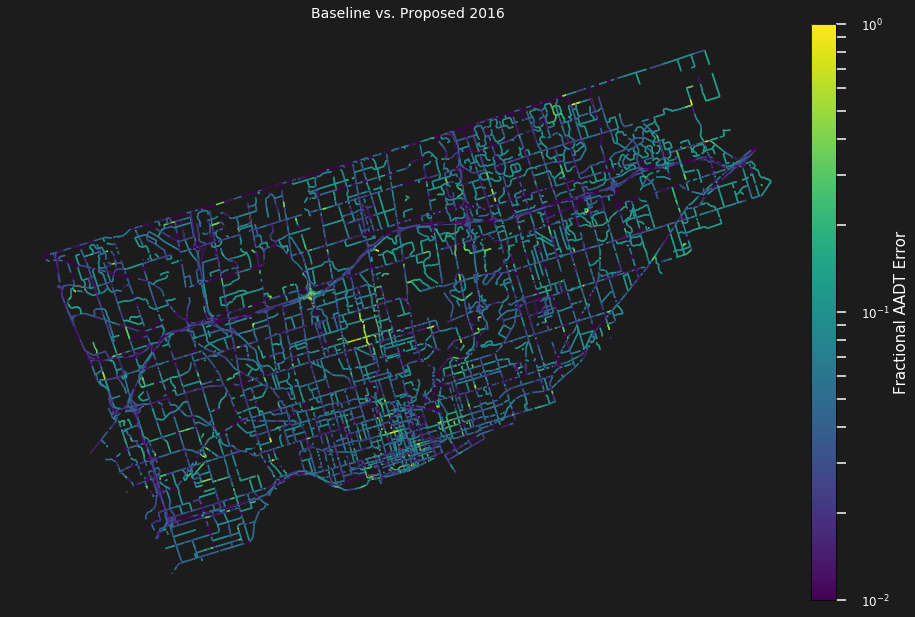

In [25]:
map_fractional_err(path_baseline, path_proposed, 2016, "Baseline vs. Proposed 2016")

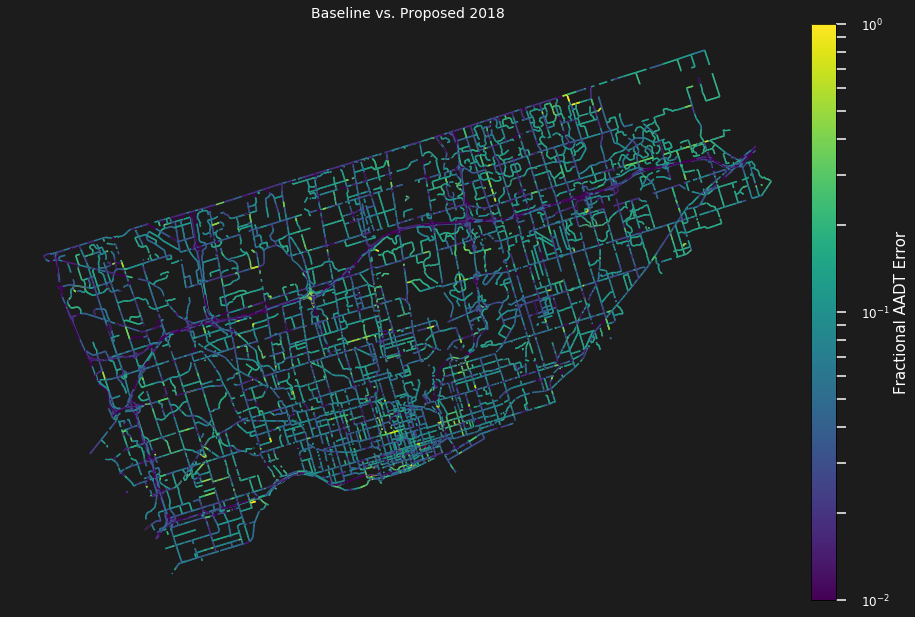

In [26]:
map_fractional_err(path_baseline, path_proposed, 2018, "Baseline vs. Proposed 2018")

I don't think there's any kind of visible spatial clustering here - instead, it looks like overall there is 10-20% error for AADT on minor roads, and closer to a few percent error on major roads.

## Comparing year-on-year citywide annually averaged daily VKT

We can estimate citywide VKT by multiplying AADT with road length, and summing up all segment-level VKTs.

In [27]:
def citywide_aavkt(path, year, getraw=False):
    df = read_csv(path, year)
    df = pd.merge(df[['centreline_id', 'dir_bin', 'aadt']],
                  centreline_lengths[['centreline', 'shape_leng_meter']],
                  how='left', left_on='centreline_id', right_on='centreline')
    df['aavkt'] = df['aadt'].values * df['shape_leng_meter'].values / 1000.
    if getraw:
        return df
    return df['aavkt'].sum()

In [36]:
baseline_aavkt = [citywide_aavkt(path_baseline, year) for year in range(2006, 2019)]
baseline_aavkt += [np.nan,]
proposed_aavkt = [citywide_aavkt(path_proposed, year) for year in range(2006, 2020)]
df_aavkt = pd.DataFrame({'baseline': baseline_aavkt, 'proposed': proposed_aavkt}, index=range(2006, 2020))

In [37]:
df_aavkt

,baseline,proposed
2006,5.920086e+07,5.918671e+07
2007,6.001631e+07,6.008497e+07
2008,6.061885e+07,6.062783e+07
2009,6.219162e+07,6.199892e+07
2010,6.313190e+07,6.284900e+07
2011,6.402116e+07,6.393199e+07
2012,6.594074e+07,6.552766e+07
2013,6.792996e+07,6.760883e+07
2014,6.764927e+07,6.724798e+07
2015,6.862255e+07,6.857542e+07


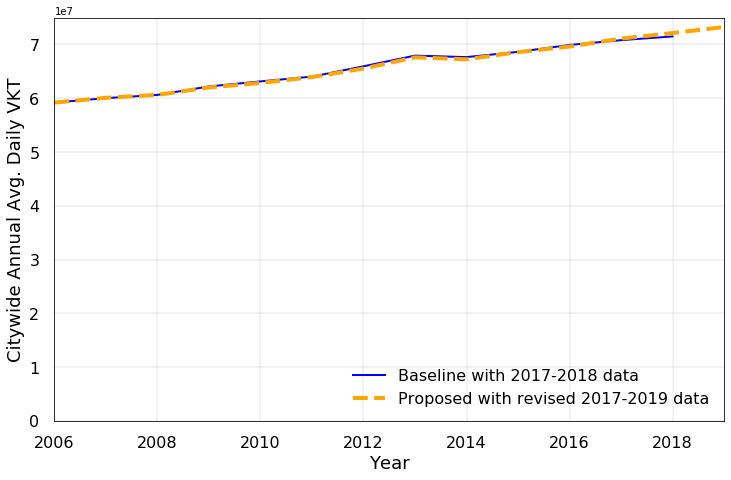

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.subplots_adjust(bottom=0.2, top=0.9)
df_aavkt.plot(ax=ax, y='baseline', label='Baseline with 2017-2018 data', lw=2, color='blue')
df_aavkt.plot(ax=ax, y='proposed', label='Proposed with revised 2017-2019 data', ls='--', lw=4, color='orange')
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.set_ylim([0, 7.5e7])
ax.set_xlabel("Year", fontsize=18)
ax.set_ylabel("Citywide Annual Avg. Daily VKT", fontsize=18)
ax.tick_params(axis='both', which='both', labelsize=16, length=0, pad=15)
ax.legend(loc=4, facecolor='white', frameon=False, fontsize=16);

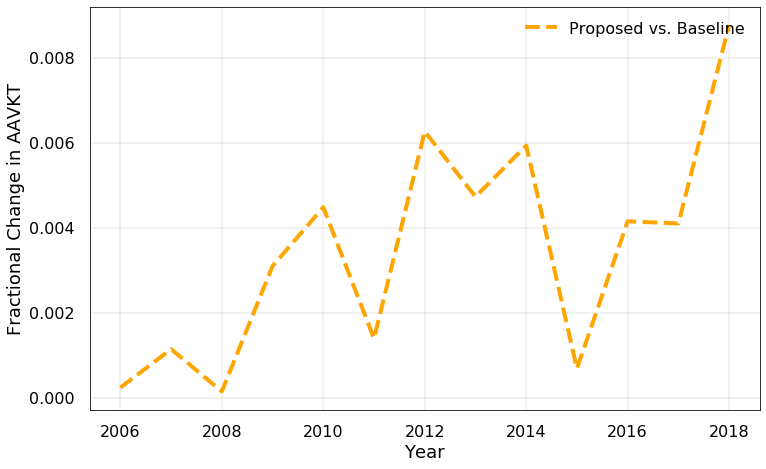

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.subplots_adjust(bottom=0.2, top=0.9)
ax.plot(df_aavkt.index.values, abs(df_aavkt['proposed'].values - df_aavkt['baseline'].values) / df_aavkt['baseline'].values,
        label='Proposed vs. Baseline', color='orange', lw=4, ls='--')
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.set_xlabel("Year", fontsize=18)
ax.set_ylabel("Fractional Change in AAVKT", fontsize=18)
ax.tick_params(axis='both', which='both', labelsize=16, length=0, pad=15)
ax.legend(loc=1, facecolor='white', frameon=False, fontsize=16);

The citywide averages are very close to one another!  The recalculated data is essentially identical in the aggregate to the baseline, deviating by less than 0.5% for any given year.  The proposed, which includes 2017-2018 data, diverges less and less significantly as we approach 2016, where the error is also around 0.5%.